In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import re
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


########## 1. Download the Data ##########

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1A How many training and test data points are there?

print(f"Number of training data points: {train.shape[0]}")
print(f"Number of test data points: {test.shape[0]}")

Number of training data points: 7613
Number of test data points: 3263


In [24]:
# 1A what percentage of the training tweets are real disasters and are not?

percent_real = (train["target"].sum()/ train.shape[0]) * 100
print(f"the percentage of real disasters in the training set is: {round(percent_real, 2)} % ")
print(f"the percentage of tweets that are not actual disasters in the training set is: {round(100 - percent_real,2)}%")



the percentage of real disasters in the training set is: 42.97 % 
the percentage of tweets that are not actual disasters in the training set is: 57.03%


In [25]:
# 1b Split the training data set into a training set and development set 70/30

training_split = train.sample(frac = .70)
development_split = train.drop(training_split.index)

In [26]:
# 1C - remove all Twitter tags


training_split['text'] = training_split['text'].replace(r'@[A-Za-z0-9]+', '', regex=True)
development_split['text'] = development_split['text'].replace(r'@[A-Za-z0-9]+', '', regex=True)

In [27]:
# 1C Preprocess the data

# 1C - overting all letters to lowercase
training_split['text'] = training_split.text.apply(lambda x: x.lower())
development_split['text'] = development_split.text.apply(lambda x: x.lower())

In [28]:
# 1C -  remove all special characters and punctuation

training_split['text'] = training_split['text'].replace(r'[^\w\s]|_', '', regex=True)
development_split['text'] = development_split['text'].replace(r'[^\w\s]|_', '', regex=True)


In [29]:
# 1C - remove all URLS (e.g. https and www.)

training_split['text'] = training_split['text'].replace(r'http\S+|www.\.\S+', '', regex=True)
development_split['text'] = development_split['text'].replace(r'http\S+|www.\.\S+', '', regex=True)

In [30]:
# 1C - strip all the stop words (e.g. the, and, or)


training_split['text'] = training_split['text'].replace(r'(\s*\b(?:a|an|and|are|as|at|be|but|by|for|if|in|into|is|it|no|not|of|on|or|such|that|the|their|then|there|these|they|this|to|was|will|with|my|oh|i|were|werent|was|wasnt|do|does))\b', '', regex=True)
development_split['text'] = development_split['text'].replace(r'(\s*\b(?:a|an|and|are|as|at|be|but|by|for|if|in|into|is|it|no|not|of|on|or|such|that|the|their|then|there|these|they|this|to|was|will|with|my|oh|i|were|werent|was|wasnt|do|does))\b', '', regex=True)


In [31]:
# 1C - Lemmatize all the words

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk import tokenize, stem, corpus


lemmatizer = stem.WordNetLemmatizer()

# Get the POS Tag for lemmatization (reference: https://medium.com/@yashj302/lemmatization-f134b3089429 )
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {'j': corpus.wordnet.ADJ,
                'n': corpus.wordnet.NOUN,
                'v': corpus.wordnet.VERB,
                'r': corpus.wordnet.ADV}
    return tag_dict.get(tag, corpus.wordnet.NOUN)

# apply lemmatizer on the text column
training_split['text'] = training_split.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in tokenize.word_tokenize(x)]))
development_split['text'] = development_split.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in tokenize.word_tokenize(x)]))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joshuamisir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joshuamisir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joshuamisir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# 1d) Bag of words model & determining optimal M

f1_trainlist = []
f1_devlist = []

# threshold for bag of words 
for M in range(12, 30):

# Perform CountVectorizer on text. This creates three numbers:
# 1) list of rows which represent tweets
# 2) a feature index which represents a distinct word within that tweet 
# 3) a count which represents how many times that word has been used
    
    count_vect = CountVectorizer(binary=True, min_df=M)
    X_train = count_vect.fit_transform(training_split['text'])

    # need to make dev set transformed to fit X_train size
    X_dev = count_vect.transform(development_split['text'])

    # create logistic model
    logreg = LogisticRegression(multi_class='auto', penalty='none', max_iter=3000)
    logreg.fit(X_train, training_split['target'].values)

    # calculate F1 score
    f1_train = f1_score(training_split['target'].values, logreg.predict(X_train))
    f1_dev = f1_score(development_split['target'].values, logreg.predict(X_dev))

    f1_trainlist.append(f1_train)
    f1_devlist.append(f1_dev)

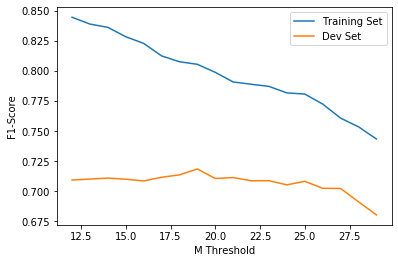

In [42]:
# plot to determine optimal M
plt.plot(range(12, 30), f1_trainlist, label="Training Set")
plt.plot(range(12, 30), f1_devlist, label="Dev Set")
plt.xlabel("M Threshold")
plt.ylabel("F1-Score")
leg = plt.legend(loc='upper right')
plt.show()

# F1-Dev Score is maxed at ~M = 13

In [34]:
M = 13

# Perform CountVectorizer on text
count_vect = CountVectorizer(binary=True, min_df=M)
X_train = count_vect.fit_transform(training_split['text'])

# need to make dev set transformed to fit X_train size
X_dev = count_vect.transform(development_split['text'])

In [35]:
# 1e) i - LogisticRegression with no regularization. Penalty = none

# The F1 score on the training set is higher than the F1 score on the development set which contains unseen data
# This is an example of  overfitting. 
# Our model is too strongly fitted to the training data when there is no regularization in the Logistic Regression
# This is due to the fact that there is no regularization factor in this logistic regression.
# The lack of regularization makes this model too sensative to the "noise" (data points that dont truly represent the data) 
# in the data set

logreg = LogisticRegression(multi_class='ovr', penalty='none', max_iter=2500)
logreg.fit(X_train, training_split['target'].values)

# calculate F1 score
f1_train = f1_score(training_split['target'].values, logreg.predict(X_train))
f1_dev = f1_score(development_split['target'].values, logreg.predict(X_dev))


# print F1 values out
#print(f"Training set with no regularization terms F1-Score is: {round(f1_train,3)}")
#print(f"Development set with no regularization terms F1-Score is: {round(f1_dev,3)}")

print(f"Training set with no regularization terms F1-Score is: {f1_train}")
print(f"Development set with no regularization terms F1-Score is: {f1_dev}")

Training set with no regularization terms F1-Score is: 0.8389888408107492
Development set with no regularization terms F1-Score is: 0.7101827676240209


In [36]:
# 1e) ii - LogisticRegression with L1 regularization. 


logreg1 = LogisticRegression(penalty='l1', max_iter=2500, solver='liblinear')
logreg1.fit(X_train, training_split['target'].values)

# calculate F1 score
f1_train_reg1 = f1_score(training_split['target'].values, logreg1.predict(X_train))
f1_dev_reg1 = f1_score(development_split['target'].values, logreg1.predict(X_dev))


#print F1 values out
print(f"Training set with L2 regularization F1-Score is {f1_train_reg1}")
print(f"Development set with L2 regularization F1-Score is {f1_dev_reg1}")

Training set with L2 regularization F1-Score is 0.8085405912717033
Development set with L2 regularization F1-Score is 0.7231021299836154


In [37]:
# 1e) iii - LogisticRegression with L2 regularization. 


logreg2 = LogisticRegression(penalty='l2', max_iter=2500)
logreg2.fit(X_train, training_split['target'].values)

# calculate F1 score
f1_train_reg2 = f1_score(training_split['target'].values, logreg2.predict(X_train))
f1_dev_reg2 = f1_score(development_split['target'].values, logreg2.predict(X_dev))


#print F1 values out
print(f"Training set with L2 regularization F1-Score is {f1_train_reg2}")
print(f"Development set with L2 regularization F1-Score is {f1_dev_reg2}")

Training set with L2 regularization F1-Score is 0.8225391629646949
Development set with L2 regularization F1-Score is 0.7241192411924119


In [38]:
# 1e) iv - Which one of the three classifiers performed the best on your training and development set?

# The best performing model on both the training and development set was the 
# Logistic Regression with L2 regularization. 
# The superior outcomes for this logistic regression can best be explained by the fact that L2
# squares the magnitude of the coeffecicients whereas the L1 regularization takes the absolute value
# of the coeffecients


In [39]:
# 1e) v.  Inspect weight vector of classifier with L1 regularization

# retrieve index from coefficiets that are greater than a value
impt_index = [i for i,v in enumerate(logreg1.coef_.tolist()[0]) if v > 1.5]

# map the index to the actual words
impt_words = [count_vect.get_feature_names()[i] for i in impt_index]

# The most important words in determining if the Tweet was a real disaster
print(impt_words)


['bioterror', 'bomber', 'bombing', 'bridge', 'bus', 'casualty', 'catastrophic', 'coach', 'crew', 'cyclone', 'derailment', 'drought', 'earthquake', 'evacuation', 'explosion', 'flood', 'found', 'hailstorm', 'helicopter', 'hiroshima', 'japan', 'legionnaire', 'libya', 'massacre', 'mh370', 'migrant', 'murder', 'muslim', 'myanmar', 'near', 'outbreak', 'refugee', 'rioting', 'severe', 'spill', 'storm', 'survivor', 'swallow', 'terrorism', 'terrorist', 'tornado', 'train', 'typhoon', 'victim', 'village', 'volcano', 'wildfire']


In [40]:
# The most important words in determining if the Tweet was a real
# disaster or not are listed below

# '40', 'bioterror', 'bomber', 'bombing', 'bus', 'california', 'case'
#  casualty', 'crew', 'crisis', 'cyclone', 'debris', 'derailment'
# 'earthquake', 'explosion', 'fire', 'hiroshima', 'hurricane', 'israeli', 
# japan', 'massacre', 'mh370', 'migrant', 'murder', 'murderer', 'muslim',
# 'outbreak', 'refugee', 'severe', 'sinkhole', 'south', 'spill', 'storm',
# 'suspect', 'swallow', 'terrorist', 'train', 'typhoon', 'village'
# 'volcano', 'wildfire'

In [41]:
X_train.shape[1]

850

In [44]:
#1f) Bernoulli Naive Bayes

# laplace smoothing parameter
alpha = .01

# create array of target values
y_train = training_split['target'].values

# convert Xtrain to array for manipulation
X_train = X_train.toarray()
n = X_train.shape[0]    # size of the data set
d = X_train.shape[1]    # number of features in the data set
K = 2                   #number of classes (Real/not real disasters)

# initialize shapes of parameters

#An array with two rows (classes, K) and 798 cols (features, d)
psis = np.zeros([K,d]) 

# An array with K (2) number of rows
phis = np.zeros([K])


# calculate the parameters, and apply alpha
for k in range(K):
    X_k = X_train[y_train == k]
    psis[k] = (np.sum(X_k, axis=0) + alpha)/(X_k.shape[0] + 2*alpha)
    phis[k] = X_k.shape[0] / float(n)
    
print(phis)

[0.57252768 0.42747232]


In [45]:
def nb_predictions(x, psis, phis):
    """This returns class assignments and scores under the NB model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d))
    psis = np.reshape(psis, (K, 1, d))
    
    # clip probabilities to avoid log(0)
    psis = psis.clip(1e-14, 1-1e-14)
    
    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

idx_train, logpyx_train = nb_predictions(X_train, psis, phis)


(idx_train==y_train).mean()

0.811033965096641

In [46]:

# calculate the predictions for dev set

y_dev = development_split['target'].values

# convert Xtrain to array for manipulation
X_dev = X_dev.toarray()

idx_dev, logpyx_train = nb_predictions(X_dev, psis, phis)

# calculate the accurary
(idx_dev==y_dev).mean()



0.7876532399299475

In [ ]:
# Which model performed the best in predicting whether a tweet is of a real disaster or
# not? Include your performance metric in your response. 
# Comment on the pros and cons of using generative vs discriminative models. 
# • Think about the assumptions that Naive Bayes makes. 
# How are the assumptions different from logistic regressions? Discuss whether it’s valid and efficient to use Bernoulli
# Naive Bayes classifier for natural language texts.



# 1g) The Naive Bayes model produced a better result with an accuracy rate of 80% vs. Logistic regression, which had 
# a F1-score of 72%. 
# However, NB method assumes that all the words are not correlated, which isn't true. This results in the probabilities
# being overconfidenti n its predictions. It's valid to use Bernoulli NB classifier if the feature space is small, as it'll
# reduce the number of instances of dependent features. Otherwise, if the feature space is large, Logistic regression is better

# This can be measuered in practice. For example if you have a classification problem where you are attempting to
# classify what city a news article is being published for, either Boston or New York. Lets assume Boston 
# and New York are refenced equally throughout the text in their respective classes. "New York" will contribute
# twice the weight as one instance of "Boston". The summed contribution of the classification weights may be larger
# for one class than another which will cause the NB model to favor one class over the other. 






# One issue with Naive Bayes is that if there is unequal representativeness of class representations in the training data 
# within a binary classification problem, there will be a bias toward that over-represented class. This will degrade accuracy 

# Another assumption is that Naive Bayes assumes that words are idependent and identically distributed which 
# is a faulty assumption and is not the case in practice. 
# Certain pairs of words within sentences have a high likelihood of being seen together
# which reduces the strength of the identical, independent distrubtion Naive Bayes makes. 

# 


In [47]:
# Rebuild dataset and re-train on NB with 2-grams

h_train = pd.read_csv('train.csv')
h_test = pd.read_csv('test.csv')

# Pre-processing the data

# remove all lowercase from the tweet
h_train['text'] = h_train.text.apply(lambda x: x.lower())
h_test['text'] = h_test.text.apply(lambda x: x.lower())

# remove all Twitter tags
h_train['text'] = h_train['text'].replace(r'@[A-Za-z0-9]+', '', regex=True)
h_test['text'] = h_test['text'].replace(r'@[A-Za-z0-9]+', '', regex=True)

# remove all special characters, including punctuation
h_train['text'] = h_train['text'].replace(r'[^\w\s]|_', '', regex=True)
h_test['text'] = h_test['text'].replace(r'[^\w\s]|_', '', regex=True)

# remove all URLs
h_train['text'] = h_train['text'].replace(r'http\S+|www.\.\S+', '', regex=True)
h_test['text'] = h_test['text'].replace(r'http\S+|www.\.\S+', '', regex=True)

# strip all the stop words (e.g. the, and, or)
h_train['text'] = h_train['text'].replace(r'(\s*\b(?:a|an|and|are|as|at|be|but|by|for|if|in|into|is|it|no|not|of|on|or|such|that|the|their|then|there|these|they|this|to|was|will|with|my|oh|i|were|werent|was|wasnt|do|does))\b', '', regex=True)
h_test['text'] = h_test['text'].replace(r'(\s*\b(?:a|an|and|are|as|at|be|but|by|for|if|in|into|is|it|no|not|of|on|or|such|that|the|their|then|there|these|they|this|to|was|will|with|my|oh|i|were|werent|was|wasnt|do|does))\b', '', regex=True)

# lemmatize the words
h_train['text'] = h_train.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in tokenize.word_tokenize(x)]))
h_test['text'] = h_test.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in tokenize.word_tokenize(x)]))



In [69]:
# 1h) countvector with n-grams = 1,2

count_vect = CountVectorizer(binary=True,ngram_range=(1,2), min_df=4)
X_train = count_vect.fit_transform(h_train['text'])
X_test = count_vect.transform(h_test['text'])

# NB on the training data

# create array of target values
Y_train = h_train['target'].values

# convert Xtrain to array for manipulation
X_train = X_train.toarray()
n = X_train.shape[0]  # size of the data set (number of tweets)
d = X_train.shape[1]  # number of features in the data set
K = 2                 # number of classes we are classification classes

# initialize shapes of parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

# calculate the parameters, and apply alpha
for k in range(K):
    X_k = X_train[Y_train == k]
    psis[k] = (np.sum(X_k, axis=0) + alpha)/(X_k.shape[0] + 2*alpha)
    phis[k] = X_k.shape[0] / float(n)

idx_train, logpyx_train = nb_predictions(X_train, psis, phis)

# calculate the accurary
(idx_train==Y_train).mean() 

0.8518323919611192

In [70]:
# convert Xtrain to array for manipulation
X_test = X_test.toarray()

idx_test, logpyx_test= nb_predictions(X_test, psis, phis)

In [71]:
# create submission
h_test["target"] = idx_test
submission = h_test[["id","target"]]
submission.to_csv('submission_disastertweets.csv', index=False)